In [1]:
import numpy as np
import pandas as pd
import sys
import os
from datetime import datetime

sys.path.append("..") 


from tp_config import *
from tp_utils.data_provider import read_prices, read_data

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
import numpy as np

In [19]:
import os.path
import sys
import backtrader as bt

import matplotlib.pyplot as plt

In [38]:
df_raw = read_data('BNB-BTC', '15m', '2021-05-01')
df_raw['T'] = df_raw['T'].apply(lambda x: datetime.fromtimestamp(x/1000))
df_raw.to_csv('mydata.csv', index = False)


In [12]:
datapath = 'data/orcl-1995-2014.txt'

data = bt.feeds.YahooFinanceCSVData(
    dataname=datapath,
    fromdate=datetime.datetime(2000,1,1),
    todate = datetime.datetime(2000,12,31),
    reverse=False)

In [63]:
data = bt.feeds.GenericCSVData(
    dataname='mydata.csv',
       timeframe=bt.TimeFrame.Minutes,
    fromdate=datetime(2021, 5, 1),
    todate=datetime(2021, 5, 31),

    nullvalue=0.0,

    dtformat=('%Y-%m-%d %H:%M:%S'),
    compression=15,
    datetime=0,
    high=1,
    low=2,
    open=3,
    close=4,
    volume=5,
    openinterest=-1
)

In [67]:
class Strat1_2BD_5BH(bt.Strategy):
    
    def __init__(self):
        self.dataclose= self.datas[0].close    # Keep a reference to the "close" line in the data[0] dataseries
        self.order = None # Property to keep track of pending orders.  There are no orders when the strategy is initialized.
        self.buyprice = None
        self.buycomm = None
    
    
    def log(self, txt, dt=None):
        # Logging function for the strategy.  'txt' is the statement and 'dt' can be used to specify a specific datetime
        dt = dt or self.datas[0].datetime.date(0)
        print('{0},{1}'.format(self.data.datetime.datetime(),txt))
        #print('{0},{1}'.format(dt.isoformat(),txt))

    def notify_order(self, order):
        # 1. If order is submitted/accepted, do nothing 
        if order.status in [order.Submitted, order.Accepted]:
            return
        # 2. If order is buy/sell executed, report price executed
        if order.status in [order.Completed]: 
            if order.isbuy():
                self.log('BUY EXECUTED, Price: {0:8.5f}, Cost: {1:8.5f}, Comm: {2:8.5f}'.format(
                    order.executed.price,
                    order.executed.value,
                    order.executed.comm))
                
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:
                self.log('SELL EXECUTED, {0:8.5f}, Cost: {1:8.5f}, Comm{2:8.5f}'.format(
                    order.executed.price, 
                    order.executed.value,
                    order.executed.comm))
            
            self.bar_executed = len(self) #when was trade executed
        # 3. If order is canceled/margin/rejected, report order canceled
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
            
        self.order = None
    
    def notify_trade(self,trade):
        if not trade.isclosed:
            return
        
        self.log('OPERATION PROFIT, GROSS {0:8.5f}, NET {1:8.5f}'.format(
            trade.pnl, trade.pnlcomm))
    
    def next(self):
        # Log the closing prices of the series from the reference
        
        self.log('Close, {0:8.5f}'.format(self.dataclose[0]))

        if self.order: # check if order is pending, if so, then break out
            return
                
        # since there is no order pending, are we in the market?    
        if not self.position: # not in the market
            if self.dataclose[0] < self.dataclose[-1]:
                if self.dataclose[-1] < self.dataclose[-2]:
                    self.log('BUY CREATE {0:8.5f}'.format(self.dataclose[0]))
                    self.order = self.buy()           
        else: # in the market
            if len(self) >= (self.bar_executed+5):
                self.log('SELL CREATE, {0:8.5f}'.format(self.dataclose[0]))
                self.order = self.sell()

In [68]:
cerebro = bt.Cerebro()  # We initialize the `cerebro` backtester.
cerebro.adddata(data) # We add the dataset in the Data cell.
cerebro.addstrategy(Strat1_2BD_5BH) # We add the strategy described in the `Strategy class` cell
cerebro.broker.setcash(100000.0) # We set an initial trading capital of $100,000
cerebro.broker.setcommission(commission=0.001)

In [ ]:
print('Starting Portfolio Value: {0:8.2f}'.format(cerebro.broker.getvalue()))
cerebro.run()
print('Final Portfolio Value: {0:8.2f}'.format(cerebro.broker.getvalue()))

In [16]:
%matplotlib inline
cerebro.plot()


ImportError: cannot import name 'warnings' from 'matplotlib.dates' (D:\Anaconda\envs\t\lib\site-packages\matplotlib\dates.py)

## $P(p)*7.99 -P(n)*11.99 \le 0$

## $\frac{7.99} {11.99} \le \frac{1-P(p)}{P(p)}$

## $\frac{11.99} {19.98} \le P(p)$

In [2]:
init_data = {'exchange_commission': 0.075, #percent
             'start_capital'     : 1,
             'buy_correction'    : 1.0001,
             'sell_correction'   : 0.9999
            }  


def create_X(prices):
    pass
def create_Y(prices):
    pass
    
def train():
    pass
def train_opt():
    pass
def train_holdout():
    pass
def train_walkforward():
    pass
def signals():
    pass
    

In [63]:
11.99/19.98

0.6001001001001001

In [48]:
from glob import glob

pair = 'USDT'
asset = 'ETH-USDT'
tf = '5m'

data_path = DATA_PATH_CRYPTO + '/' + pair

df_raw = read_data(asset, tf, '2020-05-01')
df_raw = df_raw.reset_index(drop = True)

In [49]:
fast_window = 12
slow_window = 26
signal_window = 9
ticks = df_raw['C'].values
macd, macd_signal, macd_hist = talib.MACD(ticks, fast_window, slow_window, signal_window)

In [73]:
X = pd.DataFrame()

def macd_add(name, vec):
    X[name] = vec
    for i in range(1,6):
        col_name = name + '_' + str(i).zfill(2)
        X[col_name] = X[name].shift(i)

macd_add('macd', macd)
macd_add('macd_signal', macd_signal)
macd_add('macd_hist', macd_hist)      

In [74]:
def trend_indicator():
    X['trend'] = (talib.EMA(ticks, 200) - ticks) /ticks
X = X.dropna()    

In [75]:
def targets(df1, n=30, lower=-0.5,upper=0.5):
    Cumulated_boundary=[]
    for i in range(1,n+1):
        first_name='DiffClose'+str(i)
        second_name='DiffMin'+str(i)
        df1[first_name]=df1['C'].diff(i).shift(-i).fillna(0)/df_raw['C']*100
        df1[second_name]=np.where((df1[first_name]<lower) | (df1[first_name]>upper), i, n)
        Cumulated_boundary.append(second_name)
    df1['Period']=df1[Cumulated_boundary].min(axis=1)
    df1['Outcome']=df1.apply(lambda x:x['DiffClose'+str(x['Period']).split('.')[0]],axis=1)
    return df1

In [76]:
look_ahead = 30
X = X.iloc[:-look_ahead]
Y = targets(df_raw, look_ahead).iloc[X.index]

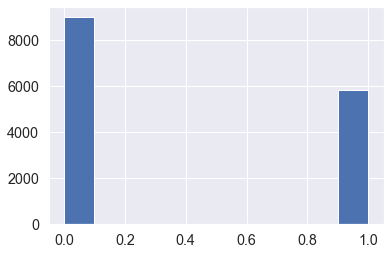

In [77]:
def labels(x):
    if x >= 0.5:
        res = 1
    else:
        res = 0
    return res

y = Y['Outcome'].apply(labels)
y.hist()

In [78]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [79]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(
    max_depth=2,
    min_samples_leaf=400,
    max_features=2,
    min_samples_split=4,
    n_estimators=1000,
)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

0.03916799702393075

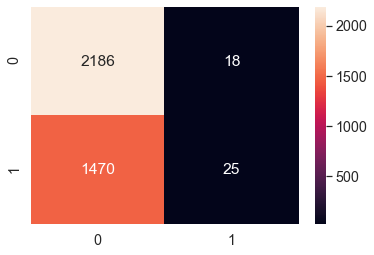

In [80]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
MCC(y_test, y_pred)

In [93]:
pp = clf.predict_proba(X_test)
good_pp = pp[predictions_proba > 0.60]
good_pp.shape

(2553,)

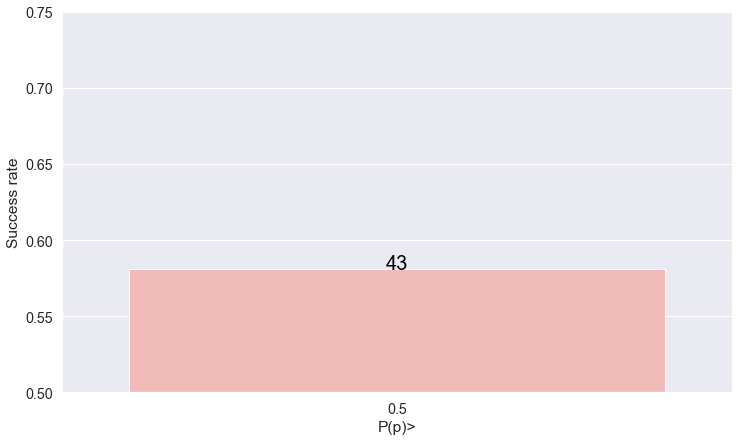

In [81]:
#conditional probability
predictions_proba = clf.predict_proba(X_test)
predictions_probability = pd.concat(
    [pd.DataFrame(predictions_proba), pd.DataFrame(y_test.values)], axis=1
)
predictions_probability.columns = ["prob_0", "prob_1", "result"]

predictions = clf.predict(X_test)
predictions_1 = pd.concat([pd.DataFrame(predictions), pd.DataFrame(y_test)], axis=1)
predictions_1.columns = ["prediction", "result"]
Results = pd.DataFrame([], columns=["P(p)>", "Success rate", "Quantity"])
for i in range(1, 10):
    P_p = np.round(0.48 + i / 50, 2)

    Quantity = len(
        (
            predictions_probability[
                predictions_probability["prob_1"] >= (0.48 + (i / 50))
            ]
        )
    )
    if Quantity == 0:
        break
    Success_rate = np.round(
        (
            predictions_probability[
                predictions_probability["prob_1"] >= (0.48 + (i / 50))
            ]["result"]
        ).sum()
        / len(
            (
                predictions_probability[
                    predictions_probability["prob_1"] >= (0.48 + (i / 50))
                ]
            )
        ),
        3,
    )
    Results = Results.append(
        {"P(p)>": P_p, "Success rate": Success_rate, "Quantity": Quantity},
        ignore_index=True,
    )
plt.figure(figsize=(12, 7))
sns.set(font_scale=1.3)
g = sns.barplot(data=Results, x="P(p)>", y="Success rate", palette="Pastel1")
plt.ylim(0.5, 0.75)
for index, row in Results.iterrows():
    g.text(
        row.name,
        row["Success rate"],
        int(row.Quantity),
        fontsize=20,
        color="black",
        ha="center",
    )

In [4]:
def count_drop(numbers):
    return len([x for x in numbers if x < 0])

def count_up(numbers):
    return len([x for x in numbers if x > 0])
  
def actual_calc(row):
    if row['Open'] > row['Adj Close']:
        return 0
    return 1
  

df  = df_raw[df_raw['T'] < 1583798400000].copy()
df['Diff'] =  (df['C'].shift(-1) - df['C'])
df['Change'] = df['Diff'].shift(1)


#df.columns = ['T', 'Open', 'High', 'Low', 'Close', 'Volume']

#df['Adj Close'] = df['Close']    
#df['Open 2'] = df['Open'].shift(1)
df['Max_7'] = df['C'].rolling(7).max()
df['Min_7'] = df['C'].rolling(7).min()
df['Mean_Change_7'] = df['Change'].rolling(7).mean()
df['Drop_7'] = df['Change'].rolling(7).apply(count_drop)
df['Up_7'] = df['Change'].rolling(7).apply(count_up)
df['Target'] = (df['Diff'] > 0).astype(int)

In [317]:
df.head(10)

,T,O,H,L,C,V,Diff,Change,Max_7,Min_7,Mean_Change_7,Drop_7,Up_7,Target
0,1547632800000,0.5355,0.5355,0.5050,0.5146,24874.41,-0.0080,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1547634600000,0.5146,0.5260,0.5003,0.5066,38490.92,0.0034,-0.0080,NaN,NaN,NaN,NaN,NaN,1
2,1547636400000,0.5146,0.5162,0.5082,0.5100,7277.02,-0.0120,0.0034,NaN,NaN,NaN,NaN,NaN,0
3,1547638200000,0.5080,0.5099,0.4980,0.4980,145952.68,-0.0088,-0.0120,NaN,NaN,NaN,NaN,NaN,0
4,1547640000000,0.4980,0.5021,0.4846,0.4892,149928.45,-0.0005,-0.0088,NaN,NaN,NaN,NaN,NaN,0
5,1547641800000,0.4892,0.4920,0.4836,0.4887,35174.33,-0.0010,-0.0005,NaN,NaN,NaN,NaN,NaN,0
6,1547643600000,0.4887,0.4896,0.4875,0.4877,19991.99,-0.0008,-0.0010,0.5146,0.4877,NaN,NaN,NaN,0
7,1547645400000,0.4877,0.4973,0.4869,0.4869,47061.34,-0.0119,-0.0008,0.5100,0.4869,-0.003957,6.0,1.0,0
8,1547647200000,0.4914,0.4920,0.4668,0.4750,111302.96,-0.0004,-0.0119,0.5100,0.4750,-0.004514,6.0,1.0,0
9,1547649000000,0.4750,0.4807,0.4730,0.4746,56706.34,0.0084,-0.0004,0.4980,0.4746,-0.005057,7.0,0.0,1


In [318]:
df = df.iloc[8:-1] 
dfx = df.drop(['T', 'Diff'], axis = 1)

In [319]:
X = dfx[dfx.columns[:-1]]
y = dfx['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [320]:
X

,O,H,L,C,V,Change,Max_7,Min_7,Mean_Change_7,Drop_7,Up_7
8,0.4914,0.4920,0.4668,0.4750,111302.96,-0.0119,0.5100,0.4750,-0.004514,6.0,1.0
9,0.4750,0.4807,0.4730,0.4746,56706.34,-0.0004,0.4980,0.4746,-0.005057,7.0,0.0
10,0.4760,0.4845,0.4760,0.4830,24642.28,0.0084,0.4892,0.4746,-0.002143,6.0,1.0
11,0.4832,0.4840,0.4768,0.4790,59353.96,-0.0040,0.4887,0.4746,-0.001457,6.0,1.0
12,0.4782,0.4821,0.4677,0.4746,61272.84,-0.0044,0.4877,0.4746,-0.002014,6.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
20012,4.0016,4.0176,3.8718,3.9237,463241.70,-0.0819,4.0056,3.9024,0.008043,2.0,5.0
20013,3.9237,3.9621,3.8740,3.8914,408474.28,-0.0323,4.0056,3.8914,-0.001571,3.0,4.0
20014,3.8882,3.9621,3.8882,3.9605,298593.12,0.0691,4.0056,3.8914,0.007771,3.0,4.0
20015,3.9604,4.0147,3.9040,4.0055,397195.91,0.0450,4.0056,3.8914,0.001500,3.0,4.0


In [325]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

clf = RandomForestClassifier(max_depth=2)
clf.fit(X_train, y_train)

# RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
#             max_depth=2, max_features='auto', max_leaf_nodes=None,
#             min_impurity_decrease=0.0, min_impurity_split=None,
#             min_samples_leaf=1, min_samples_split=2,
#             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
#             oob_score=False, random_state=0, verbose=0, warm_start=False)
clf.score(X_test, y_test)
#0.9390862944162437

0.5372313843078461

In [190]:
import keras
from keras.layers import Dense, Activation, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

    
# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_
  

num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Dense(80, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.3))
model.add(Dense(80, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(80, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(y_train.shape[1],activation='softmax'))

#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.fit(X_train, y_train, epochs=1000)

model.compile(loss='categorical_crossentropy', optimizer='adam')
#monitor = EarlyStopping(monitor='val_loss', min_delta=1e-2, patience=25, verbose=1, mode='auto')
#checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True) # save best model

In [52]:
X

array([[ 4.14700000e+03,  4.28508000e+03,  4.01600000e+03,
        -4.41857143e+00,  4.00000000e+00,  3.00000000e+00],
       [ 4.31601000e+03,  4.31601000e+03,  4.01600000e+03,
        -2.46200000e+01,  4.00000000e+00,  3.00000000e+00],
       [ 4.28071000e+03,  4.31601000e+03,  4.01600000e+03,
        -3.02185714e+01,  4.00000000e+00,  3.00000000e+00],
       ...,
       [ 9.05464000e+03,  9.05464000e+03,  8.52361000e+03,
        -6.28700000e+01,  4.00000000e+00,  3.00000000e+00],
       [ 9.13089000e+03,  9.13089000e+03,  8.52361000e+03,
        -5.16628571e+01,  4.00000000e+00,  3.00000000e+00],
       [ 8.88525000e+03,  9.13089000e+03,  8.53030000e+03,
         7.07914286e+01,  3.00000000e+00,  4.00000000e+00]])

In [ ]:
#model.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks=[monitor,checkpointer], verbose=2, epochs=1000)
model.fit(X_train, y_train, verbose= 2, epochs = 50)
#model.load_weights('best_weights.hdf5') # load weights from best model

In [194]:
pred = model.predict(X_test)

print("Shape: {}".format(pred.shape))
print(pred)

# Shape: (591, 2)
# [[1.1338343e-02 9.8866165e-01]
#  [0.0000000e+00 1.0000000e+00]
#  [1.4060745e-05 9.9998593e-01]
#  ...
#  [7.8182465e-01 2.1817538e-01]
#  [0.0000000e+00 1.0000000e+00]
#  [3.2087931e-04 9.9967909e-01]]

predict_classes = np.argmax(pred,axis=1)
print("Predictions: {}".format(predict_classes))
print("Expected: {}".format(np.argmax(y_test, axis=1)))
y_test_arg = np.argmax(y_test, axis=1)

correct = accuracy_score(y_test_arg,predict_classes)
print("Accuracy: {}".format(correct))

Shape: (8940, 2)
[[0.49373305 0.506267  ]
 [0.49373305 0.506267  ]
 [0.49373305 0.506267  ]
 ...
 [0.49373305 0.506267  ]
 [0.49373305 0.506267  ]
 [0.49373305 0.506267  ]]
Predictions: [1 1 1 ... 1 1 1]
Expected: [0 0 1 ... 0 0 0]
Accuracy: 0.5042505592841163


In [50]:
from sklearn.ensemble import RandomForestClassifier